In [1]:
import os

url_path = "https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a04/"
downloads = {"frankenstein_with_splits.csv.bz2": "frankenstein_with_splits.csv",
             "frankenstein.txt.bz2": "frankenstein.txt",
             "nlp.py": None}

for download_name, extract_name in downloads.items():
    if extract_name and os.path.exists(extract_name):
        continue

    if not os.path.exists(download_name):
        import requests
        response = requests.get(f"{url_path}{download_name}")
        with open(download_name, "wb") as fp:
            fp.write(response.content)
        response.close()

    if not extract_name:
        continue

    _, ext = os.path.splitext(download_name)
    if ext == ".bz2":    
        import bz2
        with open(download_name, 'rb') as bzf, open(extract_name, 'wb') as fp:
            fp.write(bz2.decompress(bzf.read()))
    elif ext == ".zip":
        from zipfile import ZipFile
        with ZipFile(download_name) as zf:
            zf.extractall(path=".")


# SOLUTION: Learning Embeddings with SkipGram

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm


from nlp import StepByStep, Vectorizer, Vocabulary
from collections import Counter

def allclose(a, b, atol=1e-4):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)
    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)
    return torch.allclose(a, b, atol=atol)

 # Preprocess text

In [3]:
import nltk
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open("frankenstein.txt") as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)
sentences

['Frankenstein,\n\nor the Modern Prometheus\n\n\nby\n\nMary Wollstonecraft (Godwin) Shelley\n\n\nLetter 1\n\n\nSt. Petersburgh, Dec. 11th, 17--\n\nTO Mrs. Saville, England\n\nYou will rejoice to hear that no disaster has accompanied the\ncommencement of an enterprise which you have regarded with such evil\nforebodings.',
 'I arrived here yesterday, and my first task is to assure\nmy dear sister of my welfare and increasing confidence in the success\nof my undertaking.',
 'I am already far north of London, and as I walk in the streets of\nPetersburgh, I feel a cold northern breeze play upon my cheeks, which\nbraces my nerves and fills me with delight.',
 'Do you understand this\nfeeling?',
 'This breeze, which has travelled from the regions towards\nwhich I am advancing, gives me a foretaste of those icy climes.',
 'Inspirited by this wind of promise, my daydreams become more fervent\nand vivid.',
 'I try in vain to be persuaded that the pole is the seat of\nfrost and desolation; it eve

In [4]:
import re

def preprocess_text(text):
    text = ' '.join(w for w in text.lower().split())
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

processed_sentences = [preprocess_text(s) for s in sentences]
processed_sentences

['frankenstein , or the modern prometheus by mary wollstonecraft godwin shelley letter st . petersburgh , dec . th , to mrs . saville , england you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings . ',
 'i arrived here yesterday , and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking . ',
 'i am already far north of london , and as i walk in the streets of petersburgh , i feel a cold northern breeze play upon my cheeks , which braces my nerves and fills me with delight . ',
 'do you understand this feeling ? ',
 'this breeze , which has travelled from the regions towards which i am advancing , gives me a foretaste of those icy climes . ',
 'inspirited by this wind of promise , my daydreams become more fervent and vivid . ',
 'i try in vain to be persuaded that the pole is the seat of frost and desolation it ever presents itself to my

In [5]:
def make_skipgrams(tokens, k=0):
    skipgrams = []
    n = len(tokens)
    for i in range(n - 1):
        for j in range(i + 1, min(i + k + 2, n)):
            skipgrams.append((tokens[i], tokens[j]))
    return skipgrams

positive_samples = []
for s in processed_sentences:
    skipgrams = make_skipgrams(s.split(), k = 3)
    positive_samples.extend(skipgrams)

positive_samples

[('frankenstein', ','),
 ('frankenstein', 'or'),
 ('frankenstein', 'the'),
 ('frankenstein', 'modern'),
 (',', 'or'),
 (',', 'the'),
 (',', 'modern'),
 (',', 'prometheus'),
 ('or', 'the'),
 ('or', 'modern'),
 ('or', 'prometheus'),
 ('or', 'by'),
 ('the', 'modern'),
 ('the', 'prometheus'),
 ('the', 'by'),
 ('the', 'mary'),
 ('modern', 'prometheus'),
 ('modern', 'by'),
 ('modern', 'mary'),
 ('modern', 'wollstonecraft'),
 ('prometheus', 'by'),
 ('prometheus', 'mary'),
 ('prometheus', 'wollstonecraft'),
 ('prometheus', 'godwin'),
 ('by', 'mary'),
 ('by', 'wollstonecraft'),
 ('by', 'godwin'),
 ('by', 'shelley'),
 ('mary', 'wollstonecraft'),
 ('mary', 'godwin'),
 ('mary', 'shelley'),
 ('mary', 'letter'),
 ('wollstonecraft', 'godwin'),
 ('wollstonecraft', 'shelley'),
 ('wollstonecraft', 'letter'),
 ('wollstonecraft', 'st'),
 ('godwin', 'shelley'),
 ('godwin', 'letter'),
 ('godwin', 'st'),
 ('godwin', '.'),
 ('shelley', 'letter'),
 ('shelley', 'st'),
 ('shelley', '.'),
 ('shelley', 'petersburg

## Make negative samples

In [6]:
import re

coef = 3/4



freqs = Counter(w for s in processed_sentences for w in s.split())
denom = sum(f ** coef for f in freqs.values())
probs = {w: f ** coef/ denom for w, f in freqs.items()}

ns_df = pd.DataFrame(probs.items(), columns=["word", "p"])
weights = torch.tensor(ns_df.p)

from collections import namedtuple

samples = []
for pos in tqdm(positive_samples):
    context, _ = pos
    sample = [(pos, 1)]
    
    idxs = torch.multinomial(weights, num_samples=5)
    neg_targets = tuple(ns_df.iloc[idxs].word.to_list())
    for target in neg_targets:
        neg = (context, target)
        sample.append((neg, 0))
    samples.append(sample)
    
samples


  0%|          | 0/313549 [00:00<?, ?it/s]

[[(('frankenstein', ','), 1),
  (('frankenstein', 'beheld'), 0),
  (('frankenstein', 'which'), 0),
  (('frankenstein', 'there'), 0),
  (('frankenstein', 'repaired'), 0),
  (('frankenstein', 'into'), 0)],
 [(('frankenstein', 'or'), 1),
  (('frankenstein', 'ordered'), 0),
  (('frankenstein', 'same'), 0),
  (('frankenstein', 'content'), 0),
  (('frankenstein', 'deserted'), 0),
  (('frankenstein', 'myself'), 0)],
 [(('frankenstein', 'the'), 1),
  (('frankenstein', 'those'), 0),
  (('frankenstein', 'word'), 0),
  (('frankenstein', 'comfort'), 0),
  (('frankenstein', 'and'), 0),
  (('frankenstein', 'wiliness'), 0)],
 [(('frankenstein', 'modern'), 1),
  (('frankenstein', 'although'), 0),
  (('frankenstein', 'kindness'), 0),
  (('frankenstein', 'he'), 0),
  (('frankenstein', 'barn'), 0),
  (('frankenstein', 'requisition'), 0)],
 [((',', 'or'), 1),
  ((',', 'donations'), 0),
  ((',', 'profit'), 0),
  ((',', 'easily'), 0),
  ((',', 'kindness'), 0),
  ((',', 'mournful'), 0)],
 [((',', 'the'), 1),

## Vocabulary

In [7]:
skip_vocab = Vocabulary()
skip_vocab.fill(ns_df.word)
skip_vocab    

Vocabulary({'!': 0, ',': 1, '.': 2, '?': 3, 'a': 4, 'abandon': 5, 'abandoned': 6, 'abbey': 7, 'abhor': 8, 'abhorred': 9, 'abhorrence': 10, 'abhorrent': 11, 'abide': 12, 'ability': 13, 'abject': 14, 'able': 15, 'aboard': 16, 'abode': 17, 'abortion': 18, 'abortive': 19, 'about': 20, 'above': 21, 'abroad': 22, 'abrupt': 23, 'absence': 24, 'absent': 25, 'absolute': 26, 'absolutely': 27, 'absolution': 28, 'absorbed': 29, 'absorbing': 30, 'abstained': 31, 'abstruse': 32, 'abyss': 33, 'acceded': 34, 'accent': 35, 'accents': 36, 'accept': 37, 'acceptance': 38, 'accepted': 39, 'accepting': 40, 'access': 41, 'accessed': 42, 'accessible': 43, 'accident': 44, 'accidentally': 45, 'accidents': 46, 'accompanied': 47, 'accompany': 48, 'accomplish': 49, 'accomplished': 50, 'accomplishment': 51, 'accomplishments': 52, 'accordance': 53, 'accorded': 54, 'according': 55, 'accordingly': 56, 'account': 57, 'accounted': 58, 'accounts': 59, 'accumulated': 60, 'accumulation': 61, 'accuracy': 62, 'accurate': 63,

## Vocabularization

In [8]:

x_train, y_train = [], []
for sample in tqdm(samples):
    x_item = []
    y_item = []
    for (context, target), is_positive in sample:
        x_item.append(skip_vocab.vocabularize((context, target)))
        y_item.append(1. if is_positive else 0.)
    x_train.append(torch.stack(x_item))
    y_train.append(torch.tensor(y_item))

x_train = torch.stack(x_train)
y_train = torch.stack(y_train)








  0%|          | 0/313549 [00:00<?, ?it/s]

[c p]    1
[c n1]   0
[c n2]   0
[c n3]   0
 
c * p = 1


In [9]:
x_train.shape, y_train.shape

(torch.Size([313549, 6, 2]), torch.Size([313549, 6]))

In [10]:
class SkipDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)


In [11]:

x_train[:,:,0], x_train[:,:,1]

x_train

tensor([[[2735,    1],
         [2735,  639],
         [2735, 7093],
         [2735, 6444],
         [2735, 5368],
         [2735, 3588]],

        [[2735, 4488],
         [2735, 4492],
         [2735, 5620],
         [2735, 1338],
         [2735, 1705],
         [2735, 4267]],

        [[2735, 6432],
         [2735, 6470],
         [2735, 7186],
         [2735, 1137],
         [2735,  281],
         [2735, 7126]],

        ...,

        [[4324, 2061],
         [4324, 5991],
         [4324,    1],
         [4324, 3919],
         [4324, 4434],
         [4324, 6922]],

        [[4324,    2],
         [4324, 6448],
         [4324, 2567],
         [4324,  178],
         [4324, 6466],
         [4324, 5637]],

        [[2061,    2],
         [2061, 3705],
         [2061,  853],
         [2061, 1566],
         [2061, 4208],
         [2061, 3926]]])

## The Model: SkipGram

#thumbsup

In [12]:
class SkipModel(nn.Module): # Simplified SkipGram Model
    def __init__(self, vocabulary_size, embedding_size):
        super(SkipModel, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.embeddings_context =  nn.Embedding(num_embeddings=vocabulary_size, 
                                                embedding_dim=embedding_size)
        self.embeddings_target =  nn.Embedding(num_embeddings=vocabulary_size, 
                                               embedding_dim=embedding_size)                                           

    def forward(self, x):
        batch_size = x.shape[0]
        context = x[:,:,0]
        targets = x[:,:,1]
        emb_u = self.embeddings_context(context)      # B N E   
        emb_v = self.embeddings_target(targets)       # B N E

        return torch.sigmoid(F.cosine_similarity(emb_u, emb_v, dim=-1))
        
        
        #torch.matmul(emb_context, emb_targets)
        print(context.shape, emb_context.shape, res.shape)


        print("-->", context, targets)
        #assert x_in.shape == (batch_size, )
        
        # e_c = self.embeddings_in(x)
        # #assert e_c.shape == (batch_size, self.embedding_size)

        # all_e_w = self.embeddings_out(torch.tensor([range(self.vocabulary_size)])).squeeze()
        # #assert all_e_w.shape == (self.vocabulary_size, self.embedding_size)
        
        # all_sim_w_with_c = torch.matmul(all_e_w, e_c.T).T
        # #assert all_sim_w_with_c.shape == (batch_size, self.vocabulary_size)
        
        # y_hat = F.log_softmax(all_sim_w_with_c, dim=1)
        # #assert y_hat.shape == (batch_size, self.vocabulary_size)

        # return y_hat
        


loss_func = nn.BCELoss()
model = SkipModel(len(skip_vocab), embedding_size=50)
y_hat = model(x_train)
y_hat, y_train
loss = loss_func(y_hat, y_train.float())
loss.item()
#print(loss.item())
    


0.6957916617393494

## Train

Epoch: 40  train loss: 0.47698 lr: 0.001

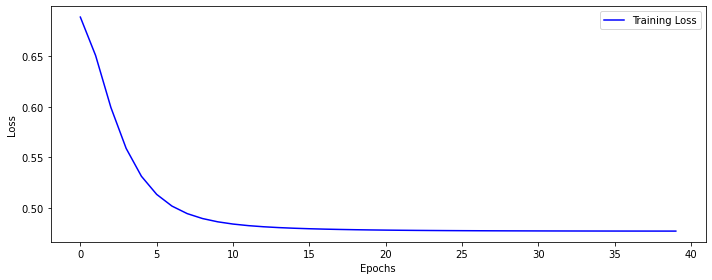

In [13]:
StepByStep.set_seed(96)

model = SkipModel(vocabulary_size=len(skip_vocab),
                  embedding_size=50)


loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(SkipDataset(x_train, y_train), batch_size=128, drop_last=True, shuffle=True)
#val_loader = DataLoader(SkipDataset(x_val, y_val), batch_size=32, drop_last=True, shuffle=True)

sbs = StepByStep(model, loss_fn, optimizer, scheduler)
sbs.set_loaders(train_loader)

sbs.train_by_loss_change(1e-5)

sbs.plot_losses(ylog=False)

In [18]:
word2vec = {word: vec.detach().clone() 
            for word, vec in zip(skip_vocab, 
                                 model.embeddings_context.weight.data)}
word2vec

{'!': tensor([-0.7788, -1.2905,  2.0428,  1.3311, -1.8725,  1.7559, -1.6694,  1.4674,
         -1.7670,  0.7237,  2.0370, -1.8020,  2.0535, -1.0047, -1.2968, -2.2277,
         -1.5387,  0.7157,  1.8648,  1.0381, -0.2019, -0.5487,  1.4813, -1.1139,
         -0.5488, -1.2515, -0.1426,  2.1056, -1.0472,  0.9266, -1.6582, -1.9953,
          0.9093, -1.9889, -1.2587, -1.0269,  0.8400, -0.6381, -1.2728, -1.5168,
          0.8867, -0.0549,  0.7880,  0.3162, -1.2267, -1.6246, -1.9026, -1.1310,
          0.1484, -1.6379]),
 ',': tensor([-1.2568, -0.8523,  1.1492,  0.8720, -1.1634,  1.0748, -1.1812,  1.1065,
         -1.1589,  0.5537,  1.2406, -1.1058,  1.2675, -0.6939, -0.8629, -1.3275,
         -0.9904,  0.5710,  0.9386,  0.7608, -0.2179, -0.7498,  0.9686, -0.5526,
         -0.0217, -0.9429,  0.5281,  1.2361, -0.7313,  0.8770, -1.1171, -1.1624,
          0.6204, -0.9566, -0.9479, -0.8745,  0.6136, -0.2126, -0.7780, -0.7884,
          0.8198,  0.1036,  0.2848,  0.2123, -0.8150, -0.9849, -1.2281

In [22]:
from sklearn.decomposition import PCA
vecs = torch.stack(list(word2vec.values()))

pca = PCA(n_components=2)
embeddings2d = pca.fit_transform(vecs)
embeddings2d

df = pd.DataFrame(embeddings2d, columns=["x", "y"])
# adding a columns for the corresponding words
df['w'] = list(skip_vocab)

import plotly.io as pio
import plotly.express as px

pio.renderers.default = "notebook"
# plotting a scatter plot
fig = px.scatter(df, x="x", y="y", text="w", log_x=True)
# adjusting the text position
fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(height=600, title_text='Word embeddings')

# displaying the figure
fig.show()


In [17]:
def save_word2vec(filename, word2vec):
    with open(filename, "w") as fp:
        for w, v in word2vec.items():
            line = f"{w} " + " ".join(map(str, v.tolist())) + "\n"
            fp.write(line)

save_word2vec("word2vec.txt", word2vec)

In [31]:
def pretty_print(results):
    for k, v in results:
        print (f"...[{v:.2f}] - {k}")

def get_closest(target_word, vocab, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """
    # Calculate distances to all other words
    word_embedding = embeddings[vocab[target_word.lower()]]
    distances = []
    for word, index in vocab.items():
        if word == vocab.pad_tok or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    results = sorted(distances, key=lambda x: x[1])[1:n+2]
    return results

word = "science"
a = get_closest(word, skip_vocab, model.embeddings_context.weight.data)
b = get_closest(word, skip_vocab, model.embeddings_target.weight.data)
a, b

([('his', tensor(0.2773)),
  ('brother', tensor(0.2813)),
  ('ernest', tensor(0.2909)),
  ('door', tensor(0.3424)),
  ('gentle', tensor(0.3443)),
  ('narration', tensor(0.3494))],
 [('elder', tensor(0.0759)),
  ('interfered', tensor(0.0771)),
  ('laboratory', tensor(0.0791)),
  ('tilbury', tensor(0.0805)),
  ('inconvenience', tensor(0.0842)),
  ('ruins', tensor(0.0851))])